# MelanomAI Main File

 ## Table of Contents
  ### Data Preparation/Preprocessing
  ### Build & Train Models
  #### Transfer Learning with ResNet50
  #### Transfer Learning with InceptionV3
  #### Transfer Learning with VGG16
  #### DenseNet based on DenseNet-121
### Not used examples



### Imports

In [2]:
import time
import numpy as np
import pandas as pd 
import os
import random
import cv2
import warnings
import matplotlib.pyplot as plt

# TensorflowKeras imports
import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras

from keras import Model as Keras_Model
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical

from tensorflow.keras import Input
from keras_tqdm import TQDMNotebookCallback

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50, VGG19, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, MaxPooling2D, Flatten, AvgPool2D, GlobalAveragePooling2D, MaxPool2D, ReLU, concatenate, GlobalMaxPooling2D, Dropout


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
warnings.filterwarnings("ignore")
from functools import partial


### Device checking

In [3]:
DEVICE = "GPU"
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
REPLICAS: 1


# Prepare the Data
## Functions to augment images

In [4]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))
def transform(image, DIM=512):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

### Function to count files

In [5]:
np.set_printoptions(threshold=15, linewidth=80)
def count_data_items(filenames):
    """ Count number of data items in TFRecord file
    INPUT: filenames:   names of tfrecord files
    OUTPUT:             how many files are stored in the tfrecord file 
    """
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
        for filename in filenames]
    return np.sum(n)

## Class to Prepare/Preprocess the Images

In [6]:
class DataPreparation():
    def __init__(self, image_size=(512,512), augment=False):
        self.image_size = image_size
        self.augment = augment



    def decode_image(self, image_data):
        """ Decode image, convert to float and resize
        INPUT:  image_data: tensor of image stored in TFRecords
                augment:    (boolean) for possible augmentation
        OUTPUT:             decoded, resized image
        """
        img = tf.image.decode_jpeg(image_data, channels=3)
        img = tf.cast(img, tf.float32) / 255.0  # convert image to floats in [0, 1] range
        if self.augment:
            img = transform(img)
            img = tf.image.random_flip_left_right(img)
            #img = tf.image.random_hue(img, 0.01)
            img = tf.image.random_saturation(img, 0.7, 1.3)
            img = tf.image.random_contrast(img, 0.8, 1.2)
            img = tf.image.random_brightness(img, 0.1)
        img = tf.reshape(img, [*self.image_size, 3]) # explicit size needed for TPU
        return img

    def read_labeled_tfrecord(self, example):
        """ Read labeled data from tfrecord and extract image and label
        INPUT:  flexible message type read from TFREcords
        OUTPUT: dataset of (image, label) pairs
        """
        LABELED_TFREC_FORMAT = {
            'image'                        : tf.io.FixedLenFeature([], tf.string),
            'image_name'                   : tf.io.FixedLenFeature([], tf.string),
            'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
            'sex'                          : tf.io.FixedLenFeature([], tf.int64),
            'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
            'anatom_site_general'          : tf.io.FixedLenFeature([], tf.int64),
            'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
            'target'                       : tf.io.FixedLenFeature([], tf.int64)
        } 
        example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
        image = self.decode_image(example['image'])
        label = example['target']
        return image, label

    def load_dataset(self, filenames, labeled=True, repeat=False, shuffle=False):
        """ Read from TFRecords. For optimal performance, reading from multiple files at once and disregarding data order. 
        INPUT:  filenames:  (array<string>) paths to the tfrecord files
                labeled:    (boolean) if the data is labeled or not (currently not implemented)
                repeat      (boolean) if the data should be repeated
                shuffle:    (boolean) if the data should be shuffled
        OUTPUT: labelled dataset containing all features from TFRecord file
        """
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
        dataset = dataset.cache()
        if repeat:
            dataset = dataset.repeat()
        if shuffle:
            dataset = dataset.shuffle(2048)
            ignore_order = tf.data.Options()
            ignore_order.experimental_deterministic = False # disable order, increase speed
            dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
        dataset = dataset.map(self.read_labeled_tfrecord, num_parallel_calls=AUTO)
        # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
        return dataset

    def get_dataset(self, FILENAMES, repeat=False, shuffle=False):
        dataset = self.load_dataset(FILENAMES, True, repeat, shuffle)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
        return dataset

### Learning Rate

In [7]:
def get_lr_callback(batch_size=32):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


# Build and Train Models
### Initialization

In [8]:
EPOCHS = 10
BATCH_SIZE = 16
VERBOSE = 0
AUTO = tf.data.experimental.AUTOTUNE
#TRAINING_FILENAMES = tf.io.gfile.glob(os.getcwd()+'/train*.tfrec')
TRAINING_FILENAMES = tf.io.gfile.glob("./tfrecords/train/200/" + "train*.tfrec")
VALIDATION_FILENAMES = [TRAINING_FILENAMES.pop()]
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))
#tqdm_callback = tf.callbacks.TQDMProgressBar()

There are 29832 train images


## Transfer Learning with ResNet50
### 1) Build Model

In [9]:
pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[512,512, 3])
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1048578   
Total params: 24,636,290
Trainable params: 1,048,578
Non-trainable params: 23,587,712
_________________________________________________________________


### 2) Train Model

In [18]:
EARLY_STOP_PATIENCE = 3
cp_callback = tf.keras.callbacks.ModelCheckpoint('./models/ResNet50.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
early_stopper_callback = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

init_train_data = DataPreparation((512,512), augment=True)
init_val_data = DataPreparation((512,512), augment=False)
training_dataset = init_train_data.get_dataset(TRAINING_FILENAMES, True, True)
validation_dataset = init_val_data.get_dataset(VALIDATION_FILENAMES, True, True)

history = model.fit(
    training_dataset,
    steps_per_epoch=count_data_items(TRAINING_FILENAMES)/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=count_data_items(VALIDATION_FILENAMES)/BATCH_SIZE,
    callbacks=[cp_callback, early_stopper_callback]
    )

Epoch 1/10
1864/1864 [==============================] - 924s 493ms/step - loss: 16.1563 - accuracy: 0.9596 - val_loss: 47.6490 - val_accuracy: 0.9712
Epoch 2/10
1864/1864 [==============================] - 922s 494ms/step - loss: 14.2252 - accuracy: 0.9630 - val_loss: 50.0846 - val_accuracy: 0.9567
Epoch 3/10
1864/1864 [==============================] - 930s 499ms/step - loss: 15.9713 - accuracy: 0.9624 - val_loss: 52.4495 - val_accuracy: 0.9712
Epoch 4/10
1864/1864 [==============================] - 914s 490ms/step - loss: 12.9542 - accuracy: 0.9657 - val_loss: 36.0775 - val_accuracy: 0.9712
Epoch 5/10
1864/1864 [==============================] - 916s 491ms/step - loss: 10.8523 - accuracy: 0.9673 - val_loss: 34.5359 - val_accuracy: 0.9712
Epoch 6/10
1864/1864 [==============================] - 923s 495ms/step - loss: 12.2308 - accuracy: 0.9648 - val_loss: 1.7205 - val_accuracy: 0.9327
Epoch 7/10
1864/1864 [==============================] - 911s 489ms/step - loss: 12.2156 - accuracy: 0

### 3) Display Trainign and Validation Accuracy

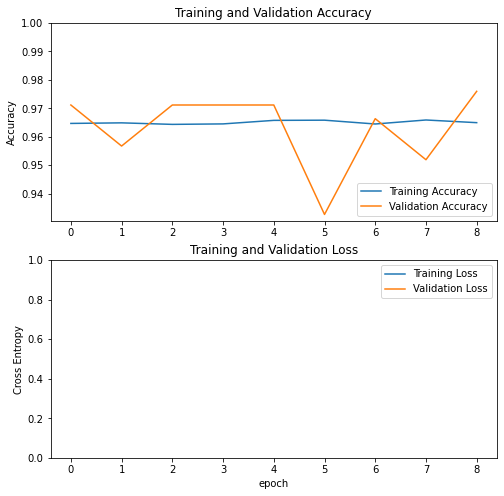

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

## 4) Testing

In [9]:
## Hand-selected AA images from ISIC
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
model.load_weights("./models/ResNet50.h5")
loss, acc = model.evaluate(test_dataset, verbose=2)

52/52 - 46s - loss: 2.9200 - accuracy: 0.8402


In [10]:
## AA Images from the internet 
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50_2/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
print(TEST_FILENAMES)
model.load_weights("./models/ResNet50.h5")
loss, acc = model.evaluate(test_dataset, verbose=2)

['.\\tfrecords\\test\\AA\\50_2\\testAA00-10.tfrec', '.\\tfrecords\\test\\AA\\50_2\\testAA01-8.tfrec']
2/2 - 2s - loss: 13.4453 - accuracy: 0.5000


In [11]:
# Hand-selected "asian" looking images from ISIC
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/A/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
model.load_weights("./models/ResNet50.h5")
loss, acc = model.evaluate(test_dataset, verbose=2)

121/121 - 81s - loss: 1.9646 - accuracy: 0.8787


In [15]:
## ISIC 2019 dataset
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/W/100/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
model.load_weights("./models/ResNet50.h5")
loss, acc = model.evaluate(test_dataset, verbose=2)

313/313 - 227s - loss: 6.4737 - accuracy: 0.7118


## Transfer Learning with InceptionV3
### 1) Build Model

In [16]:
from keras import optimizers
pre_trained_inceptionv3_model = InceptionV3(input_shape=(512,512, 3), include_top=False, weights="imagenet")
pre_trained_inceptionv3_model.trainable = False

inceptionV3_model = tf.keras.Sequential()
inceptionV3_model.add(pre_trained_inceptionv3_model)
inceptionV3_model.add(GlobalAveragePooling2D())
inceptionV3_model.add(Dropout(0.5))
inceptionV3_model.add(Dense(2,activation="softmax"))



inceptionV3_model.compile(
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
inceptionV3_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 14, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


### 2) Train Model

In [20]:
EARLY_STOP_PATIENCE = 15
cp_callback_v3 = tf.keras.callbacks.ModelCheckpoint('./models/InceptionV3.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
early_stopper_callback_v3 = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

init_train_data = DataPreparation((512,512), augment=True)
init_val_data = DataPreparation((512,512), augment=False)
training_dataset = init_train_data.get_dataset(TRAINING_FILENAMES, True, True)
validation_dataset = init_val_data.get_dataset(VALIDATION_FILENAMES, True, True)

history = inceptionV3_model.fit(
    training_dataset,
    steps_per_epoch=count_data_items(TRAINING_FILENAMES)/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    validation_steps=count_data_items(VALIDATION_FILENAMES)/BATCH_SIZE,
    callbacks=[cp_callback_v3, early_stopper_callback_v3]
    )

Epoch 1/10
1864/1864 [==============================] - 816s 437ms/step - loss: 0.0872 - accuracy: 0.9818 - val_loss: 0.1193 - val_accuracy: 0.9615
Epoch 2/10
1864/1864 [==============================] - 812s 435ms/step - loss: 0.0857 - accuracy: 0.9823 - val_loss: 0.1227 - val_accuracy: 0.9663
Epoch 3/10
1864/1864 [==============================] - 810s 434ms/step - loss: 0.0865 - accuracy: 0.9817 - val_loss: 0.1058 - val_accuracy: 0.9712
Epoch 4/10
1864/1864 [==============================] - 814s 437ms/step - loss: 0.0831 - accuracy: 0.9825 - val_loss: 0.1116 - val_accuracy: 0.9615
Epoch 5/10
1864/1864 [==============================] - 812s 436ms/step - loss: 0.0867 - accuracy: 0.9815 - val_loss: 0.1125 - val_accuracy: 0.9663
Epoch 6/10
1864/1864 [==============================] - 811s 435ms/step - loss: 0.0849 - accuracy: 0.9820 - val_loss: 0.1134 - val_accuracy: 0.9663
Epoch 7/10
1864/1864 [==============================] - 815s 437ms/step - loss: 0.0833 - accuracy: 0.9822 - val_

## 4) Testing

In [16]:
## Hand-selected AA images from ISIC

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
inceptionV3_model.load_weights("./models/InceptionV3.h5")
loss, acc = inceptionV3_model.evaluate(test_dataset, verbose=2)

52/52 - 37s - loss: 0.0934 - accuracy: 0.9806


In [17]:
## AA Images from the internet 

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50_2/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
inceptionV3_model.load_weights("./models/InceptionV3.h5")
loss, acc = inceptionV3_model.evaluate(test_dataset, verbose=2)

2/2 - 2s - loss: 2.5885 - accuracy: 0.1111


In [18]:
# Hand-selected "asian" looking images from ISIC

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/A/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
inceptionV3_model.load_weights("./models/InceptionV3.h5")
loss, acc = inceptionV3_model.evaluate(test_dataset, verbose=2)

121/121 - 63s - loss: 0.0631 - accuracy: 0.9880


In [17]:
## ISIC 2019 dataset

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/W/100/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
inceptionV3_model.load_weights("./models/InceptionV3.h5")
loss, acc = inceptionV3_model.evaluate(test_dataset, verbose=2)

313/313 - 177s - loss: 0.5260 - accuracy: 0.8544


## Transfer Learning with VGG16
### 1) Build Model

In [18]:
pretrained_vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[512,512, 3])
for layer in pretrained_vgg.layers:
    layer.trainable = False

vgg_model = tf.keras.Sequential([
    pretrained_vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

vgg_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 262146    
Total params: 14,976,834
Trainable params: 262,146
Non-trainable params: 14,714,688
_________________________________________________________________


### 2) Train Model

In [12]:
EARLY_STOP_PATIENCE = 3
BATCH_SIZE = 8
cp_callback = tf.keras.callbacks.ModelCheckpoint('./models/VGG16.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
early_stopper_callback = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)

init_vgg_train_data = DataPreparation((512,512), augment=True)
init_vgg_val_data = DataPreparation((512,512), augment=False)
vgg_training_dataset = init_vgg_train_data.get_dataset(TRAINING_FILENAMES, True, True)
vgg_validation_dataset = init_vgg_val_data.get_dataset(VALIDATION_FILENAMES, True, True)

history = vgg_model.fit(
    vgg_training_dataset,
    steps_per_epoch=count_data_items(TRAINING_FILENAMES)/BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vgg_validation_dataset,
    validation_steps=count_data_items(VALIDATION_FILENAMES)/BATCH_SIZE,
    callbacks=[cp_callback, early_stopper_callback]
    )

Epoch 1/10
3729/3729 [==============================] - 2043s 548ms/step - loss: 0.8323 - accuracy: 0.9662 - val_loss: 0.4050 - val_accuracy: 0.9650
Epoch 2/10
3729/3729 [==============================] - 2029s 544ms/step - loss: 0.8175 - accuracy: 0.9667 - val_loss: 2.0706 - val_accuracy: 0.9450
Epoch 3/10
3729/3729 [==============================] - 2041s 547ms/step - loss: 0.9151 - accuracy: 0.9666 - val_loss: 0.7231 - val_accuracy: 0.9650
Epoch 4/10
3729/3729 [==============================] - 2035s 546ms/step - loss: 0.8558 - accuracy: 0.9678 - val_loss: 1.4799 - val_accuracy: 0.9700


### 3) Visualize Training and Validation Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

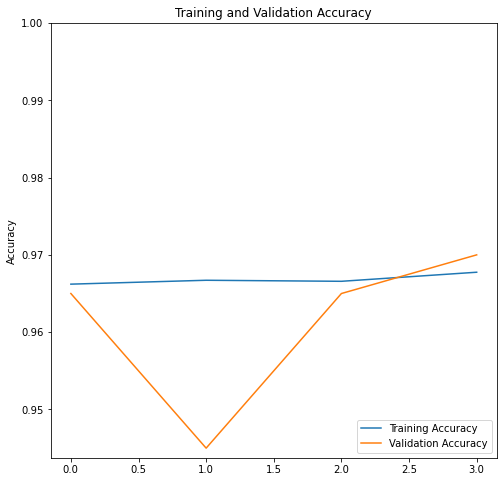

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

## 4) Testing

In [19]:
## Hand-selected AA images from ISIC
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
vgg_model.load_weights("./models/VGG16.h5")
loss, acc = vgg_model.evaluate(test_dataset, verbose=2)

ResourceExhaustedError:  OOM when allocating tensor with shape[16,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_3/vgg16/block1_conv1/Relu (defined at <ipython-input-19-c35cf527f2ad>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_33434]

Function call stack:
test_function


In [ ]:
## AA Images from the internet 

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50_2/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
vgg_model.load_weights("./models/VGG16.h5")
loss, acc = vgg_model.evaluate(test_dataset, verbose=2)

In [ ]:
# Hand-selected "asian" looking images from ISIC

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/A/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
vgg_model.load_weights("./models/VGG16.h5")
loss, acc = vgg_model.evaluate(test_dataset, verbose=2)

## DenseNet based on DenseNet-121
### 1) Build Model

In [29]:
def densenet(input_shape, n_classes, activation = "softmax", filters = 32):
  # Same sequence for each convolutional block after the input
    def bn_rl_conv(x, filters, kernel=3, strides=2):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides, padding = "same")(x)
        return x
  
    def dense_block(x, repetition):
    # Each dense block has 2 convolutions with 1x1 and 3x3 kernels
    # Each block is run for the 6,12,24,16
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)    # Every 1x1 convolutions has 4-times the number of filters
            y = bn_rl_conv(y, filters, 3)   # But 3x3 filters are oly present once
        return x
  
    def transition_layer(x):
        # Remove channels to half of the existing channels 
        x = bn_rl_conv(x, K.int_shape(x)[-1]//2)        # 1x1 convolution layer
        x = AvgPool2D(2, strides=2, padding='same')(x)  # 2x2 average poolling layer with strid of 2
        return x

    input = Input(input_shape)
    # 1st convolution block with 64 filters of size 7x7 & a stride of 2:
    x = Conv2D(64, 7, strides = 2, padding = "same")(input)
    # Max pooling laxer with 3x3 max pooling & stride of 2
    x = MaxPool2D(3, strides=2, padding="same")(x)
    
    #filters = [6,12,24,16]
    # Run 4-times trough the 6, 12, 24, 16 repetitions
    for repetition in [3,6,12,8]:
        d = dense_block(x, repetition)
        x = transition_layer(d)    

    x = GlobalAveragePooling2D()(d)
    # Final dense output layer
    output = Dense(n_classes, activation=activation)(x)
    model = Model(input, output)
    return model

## Compare to DenseNet121 from keras

In [30]:
K.clear_session()
# Save best model
sv = tf.keras.callbacks.ModelCheckpoint('./models/dense_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

with strategy.scope():
    dense_model = densenet((512,512,3), 2, "softmax")
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy() 
    dense_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    dense_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
average_pooling2d (AveragePo (None, 32, 32, 32)        0     

### 2) Train Model

In [31]:
from tqdm.notebook import tqdm
tqdm_callback = tfa.callbacks.TQDMProgressBar()
BATCH_SIZE = 8
print('Training...')
init_train_data = DataPreparation((512,512), augment=True)
init_val_data = DataPreparation((512,512), augment=False)
history = dense_model.fit(
    init_train_data.get_dataset(TRAINING_FILENAMES, True, True), 
    epochs=10, 
    callbacks = [sv, get_lr_callback(BATCH_SIZE)], 
    steps_per_epoch=count_data_items(TRAINING_FILENAMES)/BATCH_SIZE, 
    validation_data=init_val_data.get_dataset(VALIDATION_FILENAMES, False, False),
    validation_steps=count_data_items(VALIDATION_FILENAMES)/BATCH_SIZE,
    verbose=1
)

Training...
Epoch 1/10
3729/3729 [==============================] - 654s 174ms/step - loss: 0.1846 - accuracy: 0.9800 - val_loss: 0.0912 - val_accuracy: 0.9800
Epoch 2/10
3729/3729 [==============================] - 675s 181ms/step - loss: 0.0899 - accuracy: 0.9813 - val_loss: 0.0810 - val_accuracy: 0.9800
Epoch 3/10
3729/3729 [==============================] - 758s 203ms/step - loss: 0.0836 - accuracy: 0.9823 - val_loss: 0.0819 - val_accuracy: 0.9800
Epoch 4/10
3729/3729 [==============================] - 626s 168ms/step - loss: 0.0823 - accuracy: 0.9823 - val_loss: 0.0820 - val_accuracy: 0.9800
Epoch 5/10
3729/3729 [==============================] - 596s 160ms/step - loss: 0.0807 - accuracy: 0.9822 - val_loss: 0.0854 - val_accuracy: 0.9800
Epoch 6/10
 194/3729 [>.............................] - ETA: 8:40 - loss: 0.0711 - accuracy: 0.9855

KeyboardInterrupt: 

In [32]:
## Hand-selected AA images from ISIC

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
dense_model.load_weights("./models/dense_model.h5")
loss, acc = dense_model.evaluate(test_dataset, verbose=2)

104/104 - 5s - loss: 0.0994 - accuracy: 0.9806


In [33]:
## AA Images from the internet 

TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/AA/50_2/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
dense_model.load_weights("./models/dense_model.h5")
loss, acc = dense_model.evaluate(test_dataset, verbose=2)

3/3 - 0s - loss: 2.5796 - accuracy: 0.1111


In [35]:
# Hand-selected "asian" looking images from ISIC
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/A/50/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
dense_model.load_weights("./models/dense_model.h5")
loss, acc = dense_model.evaluate(test_dataset, verbose=2)

241/241 - 12s - loss: 0.0702 - accuracy: 0.9880


In [36]:
## ISIC 2019 dataset
TEST_FILENAMES = tf.io.gfile.glob("./tfrecords/test/W/100/" + "test*.tfrec")
init_test_data = DataPreparation((512,512), augment=False)
test_dataset = init_test_data.get_dataset(TEST_FILENAMES, False, False)
dense_model.load_weights("./models/dense_model.h5")
loss, acc = dense_model.evaluate(test_dataset, verbose=2)

# NOT used Implemenations
## Generalized Sequential Network

In [ ]:
class SequentialNet:
    def __init__(self, input_shape,n_classes, filters=32):
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.filters = filters
        self.model = tf.keras.Sequential()
        
        # self.topology_dict = topology_dict # contains the layers = which function is called when.
    def build_self(self, topology_list):
        for layer in topology_list:
            self.model.add(layer)
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        loss = tf.keras.losses.SparseCategoricalCrossentropy() 
        self.model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
        return self.model

### VGG List

In [ ]:
vgg_list = [
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPool2D(pool_size=(2,2),strides=(2,2)),
    Flatten(),
    Dense(units=4096,activation="relu"),
    Dense(units=4096,activation="relu"),
    Dense(units=2, activation="softmax")
]

### 1) Build VGG Model from List

In [ ]:
K.clear_session()
# Save best model
ls_sv = tf.keras.callbacks.ModelCheckpoint('./models/vggLS_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
K.clear_session()

with strategy.scope():
    # Generate the model:
    vggLS_model = SequentialNet((224,224,3),2)
    vggLS_model = vggLS_model.build_self(vgg_list) 
    vggLS_model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy() 
    vggLS_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

### 2) Train VGG Model from List

In [ ]:
print('Training...')
VERBOSE = 1
vggLS_data = DataPreparation((224,224))
vggLS_history = vggLS_model.fit(
    vggLS_data.get_dataset(TRAINING_FILENAMES, True, True),
    epochs=EPOCHS,
    callbacks = [ls_sv,get_lr_callback(BATCH_SIZE)],
    steps_per_epoch=count_data_items(TRAINING_FILENAMES)/BATCH_SIZE,
    validation_data=vggLS_data.get_dataset(VALIDATION_FILENAMES, False, False),
    verbose=VERBOSE)

## VGG Model Built from Block Function
### 1) Build VGG Model from Block Function

In [ ]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
	# add convolutional layers
	for _ in range(n_conv):
		layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
	# add max pooling layer
	layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
	return layer_in

In [29]:
K.clear_session()
# Save best model
sv = tf.keras.callbacks.ModelCheckpoint('./models/vggBlock_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
K.clear_session()

with strategy.scope():
    # Generate the model:
    vgg_input = tf.keras.Input(shape=(224,224,3))
    layer = vgg_block(vgg_input, 64,2)
    layer = vgg_block(layer, 128, 2)
    layer = vgg_block(layer, 256, 3)
    layer = vgg_block(layer, 512, 3)
    layer = vgg_block(layer, 512, 3)
    layer = Flatten()(layer)
    layer = Dense(units=4096, activation="relu")(layer)
    layer = Dense(units=4096, activation="relu")(layer)
    output = Dense(units=2, activation="softmax")(layer)
    # Create Model
    vggBlock_model = Model(inputs=vgg_input, outputs=output)
    vggBlock_model.summary()
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy() 
    vggBlock_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0     

### 2) Train Model

In [30]:
print('Training...')
VERBOSE = 1
vggBlock_data = DataPreparation((224,224))
history = vggBlock_model.fit(
    vggBlock_data.get_dataset(TRAINING_FILENAMES, True, True),
    epochs=EPOCHS,
    callbacks = [sv,get_lr_callback(BATCH_SIZE)],
    steps_per_epoch=count_data_items(TRAINING_FILENAMES)/BATCH_SIZE,
    validation_data=vggBlock_data.get_dataset(VALIDATION_FILENAMES, False, False),
    verbose=VERBOSE)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s
0/250.0           ETA: ?s - Training...
Epoch 1/10


InvalidArgumentError:  Input to reshape is a tensor with 786432 values, but the requested shape has 150528
	 [[{{node Reshape}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_8687]

Function call stack:
train_function


## Possible Visualization (test tfrecord)

In [22]:
import matplotlib.pyplot as plt
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels


def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """

    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        #print("SHAPE: ", image.shape)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, "img", subplot, not label, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

Image:  Tensor("Reshape:0", shape=(512, 512, 3), dtype=float32)


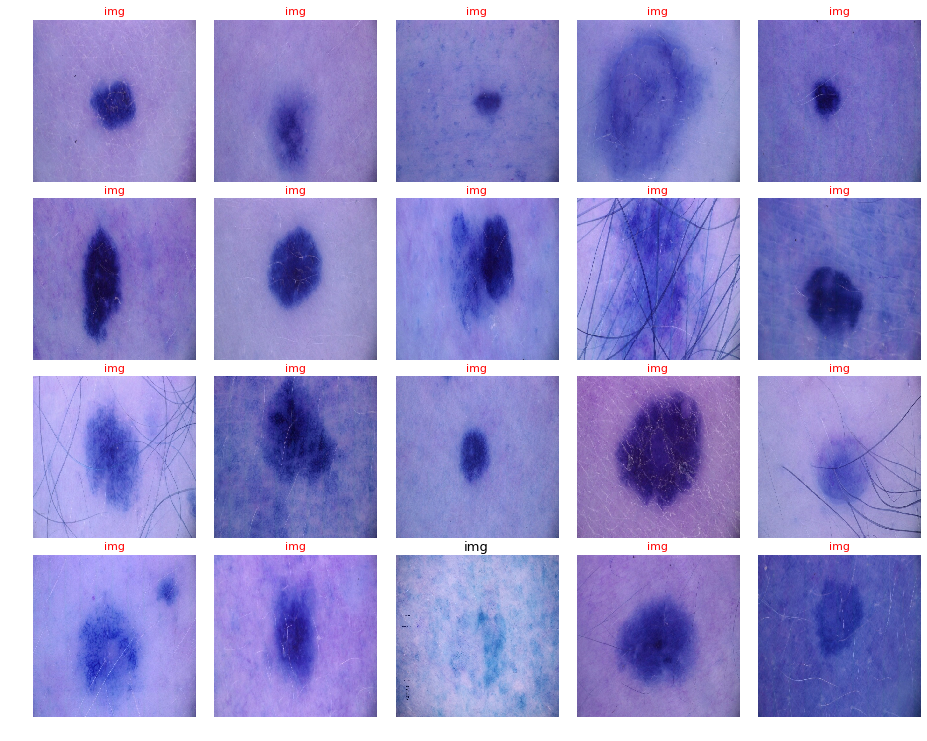

In [23]:
training_dataset = get_dataset("./tfrecords/train200-1000.tfrec")
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
display_batch_of_images(next(train_batch))